## Observed cofounder

In [ ]:
# Python tools
from dotenv import load_dotenv
import math
import networkx as nx

# Vectorization
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# models
from econml.metalearners import SLearner
from econml.dml import CausalForestDML

# Evaluators
from sklearn.metrics import root_mean_squared_error

# Initialize environment
load_dotenv()

True

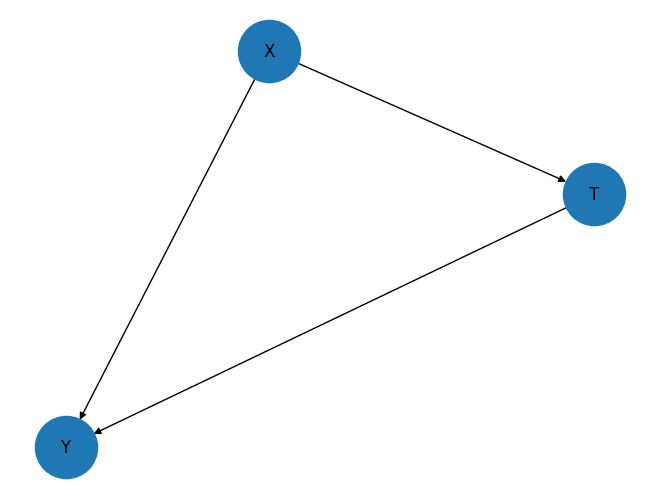

In [ ]:
edges = [["X", "Y"], ["T", "Y"], ["X", "T"]]
graph = nx.DiGraph(edges)
nx.draw(graph, with_labels=True, node_size=2000)

In [ ]:

num_samples, num_features,  = 2000, 5
noise_scale = 0.01
exogenous_scale = 0.1
heterogeneity_scale = 2

def generate_synthetic_data(
        num_samples: int = 2000,
        num_features: int = 5,
        noise_scale: float = 0.01,
        exogenous_scale: float = 0.1,
        heterogeneity_scale: float = 2,
):
    # Generate covariates
    X = np.random.normal(
        loc=0,
        scale=exogenous_scale,
        size=(num_samples, num_features)
    ).astype(np.float32)

    # Generate
    prop_eps = np.random.normal(
        loc=0, scale=noise_scale, size=(num_samples)
    ).astype(np.float32)

    # Generate
    Y_eps = np.random.normal(
        loc=0, scale=noise_scale, size=(num_samples)
    ).astype(np.float32)

    # Generate weights
    w_X_Y = np.random.uniform(size=num_features)
    w_X_T = np.random.uniform(size=num_features)
    w_X_T_effect = np.random.uniform(size=num_features)

    # Treatment and Control
    T_0 = np.zeros(shape=num_samples).astype(np.float32)
    T_1 = np.ones(shape=num_samples).astype(np.float32)

    base_X_Y = np.sum(w_X_Y * X, axis=1)
    base_X_T = np.sum(w_X_T * X, axis=1)
    heterogeneity_term = np.sum(w_X_T_effect * X, axis=1)

    propensity = np.sin(base_X_T) + prop_eps
    T = (propensity > propensity.mean()).astype(np.float32)

    Y_0 = np.cos(base_X_Y) + np.sin(0.3 * T_0) + Y_eps
    Y_1 = np.cos(base_X_Y) + np.sin(0.3 * T_1 + heterogeneity_scale * heterogeneity_term) + Y_eps

    Y = Y_0 * (1 - T) + Y_1 * T
    tau = Y_1 - Y_0
    return X, T, Y, Y_0, Y_1, tau

In [13]:
X, T, Y, Y_0, Y_1, tau = generate_synthetic_data(
    num_samples=num_samples,
    num_features=num_features,
    noise_scale=noise_scale,
    exogenous_scale=exogenous_scale,
    heterogeneity_scale=heterogeneity_scale,
)

In [ ]:
df = pd.DataFrame(
    {
        **{f"x{i}": X[:, i] for i in range(num_features)},
        "treatment": T,
        "outcome": Y,
        "y0": Y_0,
        "y1": Y_1,
        "ite": tau,
    }
)

In [24]:
df.to_csv("benchmark/data/synthetic_data_1.csv", index=False)

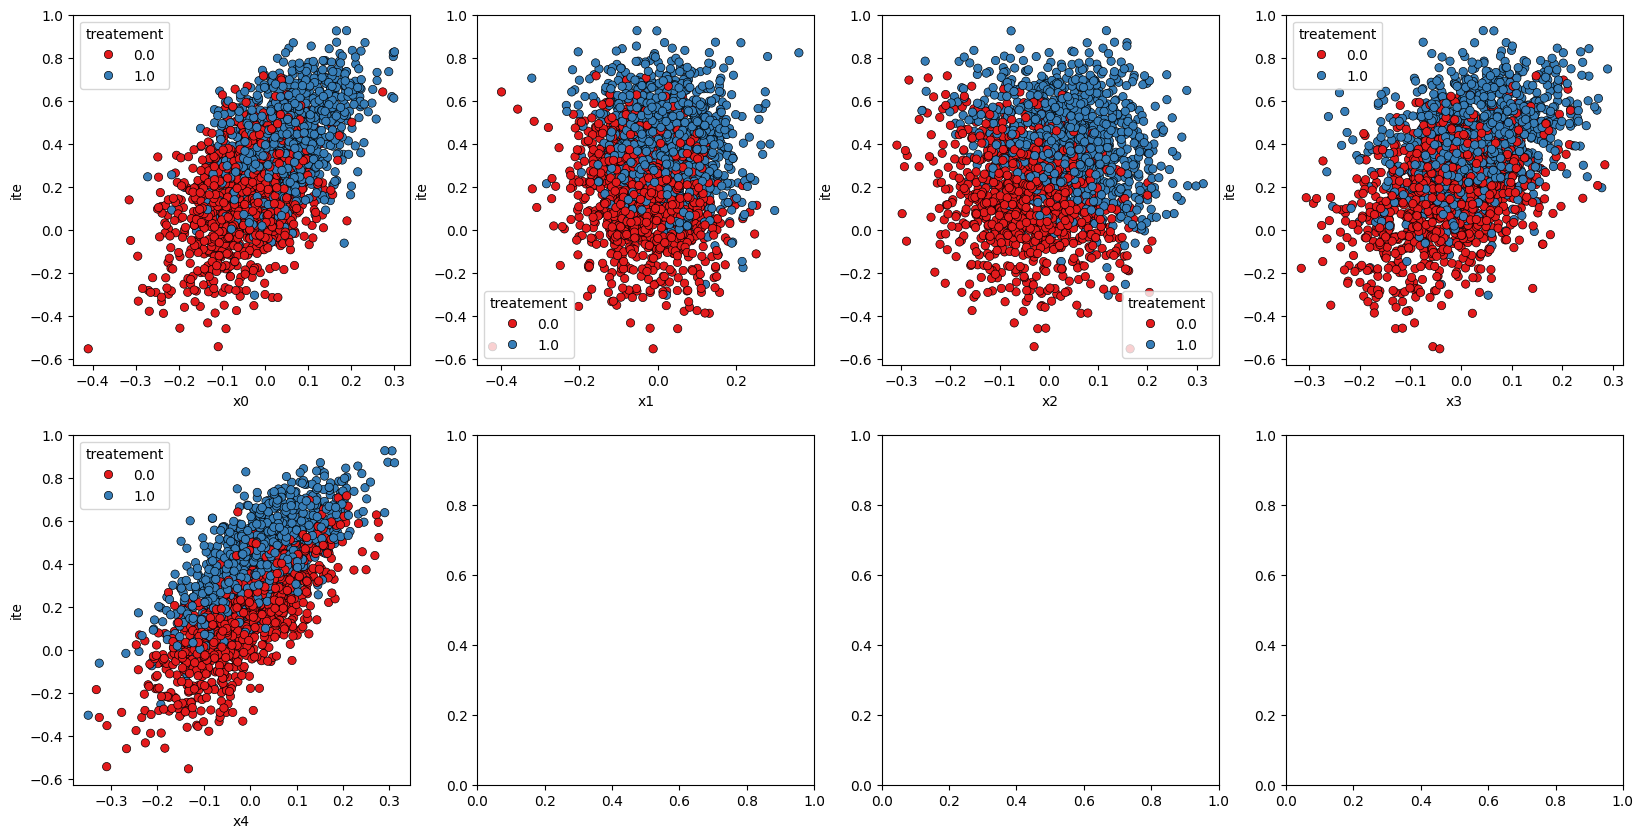

In [20]:
fig, axes = plt.subplots(
    ncols=4,
    nrows=num_features // 4 + int(bool(num_features % 4)),
    figsize=(20, 10)
)
for i in range(num_features):
    sns.scatterplot(
        data=df,
        x=f"x{i}",
        y="ite",
        hue="treatement",
        ax=axes[i // 4, i % 4],
        edgecolor="black",
        palette="Set1"
    )

In [21]:
train_portion = .75
train_size = math.floor(num_samples * train_portion)
perm = np.random.permutation(num_samples)

train_idx, test_idx = perm[:train_size], perm[train_size:]
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]
T_train, T_test = T[train_idx], T[test_idx]
tau_test = tau[test_idx]